# Advanced Lane Finding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob 
import pickle
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
def camera_calibration(images, output=False):
    
    # Path for images to be calibrated
    images = glob.glob(images)

    # Chessboard size
    nx = 9
    ny = 6

    # Arrays to store object points and image points from images
    objpoints = [] # 3d points in real world space.
    imgpoints = [] # 2d points in image plane.

    # Prepare object points
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates, z stays 0

    # Find chessboard corners
    for image in images:
        
        # Load image
        img = cv2.imread(image)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points and image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            if output:
                plt.figure(figsize=(15,10))
                plt.imshow(img)

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                       imgpoints, 
                                                       gray.shape[::-1], 
                                                       None, None)

    return mtx, dist

In [3]:
def undistort(image, mtx, dist):

    # Undistort image
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    return dst

In [4]:
def gaussian_blur(image, kernel_size=5):

    # Apply gaussian blur
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    return blurred

In [5]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply sobel depending on orientation
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    # Take the absolute value of sobel
    abs_sobel = np.absolute(sobel)
    
    # Take the max value of sobel
    max_value = np.max(abs_sobel)
    
    # Scale sobel
    scaled_sobel = np.uint8(255*abs_sobel/max_value)
    
    # Return the binary image
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary

In [6]:
def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply sobel_x and sobel_y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale gradmag
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Return the binary image
    binary = np.zeros_like(gradmag)
    binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary

In [7]:
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # Calculate direction of gradient
    arctan = np.arctan2(abs_sobel_y,abs_sobel_x)
    arctan = np.absolute(arctan)
    
    # Return the binary image
    binary = np.zeros_like(arctan)
    binary[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    return binary

In [8]:
def s_thresh(img, thresh=(0, 255)):
    
    # Covnert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel
    s = hls[:, :, 2]
    
    # Return binary image
    binary = np.zeros_like(s)
    binary[(s >= thresh[0]) & (s <= thresh[1])] = 1
    
    return binary

In [9]:
def thresholded(img):
    
    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # Apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # Apply gradient direction threshold so that only edges closer to vertical are detected
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # Combine the gradient and direction thresholds
    binary_combined = ((sx_binary == 1) & (dir_binary == 1))
    
    # Apply R & G thresholds so that yellow lanes are detected well
    color_thresh = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_binary = (R > color_thresh) & (G > color_thresh)
    
    
    # Color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # Apply threhold to the S channel 
    s_thresh = (100, 255)
    s_binary = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # Apply threshold to the L channel to avoid pixels which have shadows
    l_thresh = (120, 255)
    l_binary = (L > l_thresh[0]) & (L <= l_thresh[1])

    # Combine all thresholds
    color_combined[(r_g_binary & l_binary) & (s_binary | binary_combined)] = 1
    
    # Mask the region of interest 
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

In [10]:
def warp(img, src=None, dst=None):

    # Define calibration box 
    img_size = (img.shape[1], img.shape[0])
    
    # Define source and destination coordinates
    if src is None:
        src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst is None:
        dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)

    
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

In [11]:
def plot_result(imgs, names, rows=0, cols=0):
    
    if (len(imgs)==0 or len(names)==0): 
        return -1
    
    f, ax = plt.subplots(rows, cols, figsize=(16,8))
    f.tight_layout()
    i = 0
    if rows <= 1 :
        for c in range(cols):
            ax[c].imshow(imgs[i], cmap='gray')
            ax[c].set_title('{}'.format(names[i]), fontsize=24)
            ax[c].axis('off')
            i += 1
    else:
        for r in range(rows):
            for c in range(cols):
                ax[r, c].imshow(imgs[i], cmap='gray')
                ax[r, c].set_title('{}'.format(names[i]), fontsize=24)
                ax[r, c].axis('off')
                i += 1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Camera Calibration

In [12]:
# Camera calibration 

mtx, dist = camera_calibration('./camera_cal/calibration*.jpg')

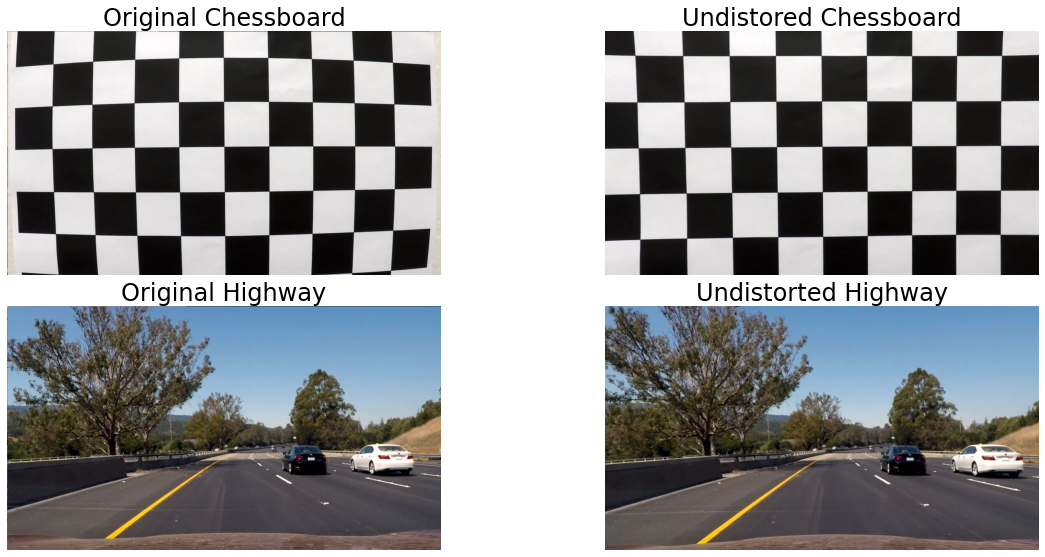

In [13]:
# Raw test image
image = mpimg.imread('test_images/test6.jpg')

# Raw camera calibration image
image_cc = mpimg.imread('camera_cal/calibration1.jpg')
undistorted_cc = undistort(image_cc, mtx, dist)

# Undistort test image
undistorted = undistort(image, mtx, dist)
    
    
# Plot the result
imgs = [image_cc, undistorted_cc, image, undistorted]
names = ['Original Chessboard' ,'Undistored Chessboard','Original Highway','Undistorted Highway']
plot_result(imgs, names, 2, 2)

## Color and Gradient Transforms

### Gradient Thresholds

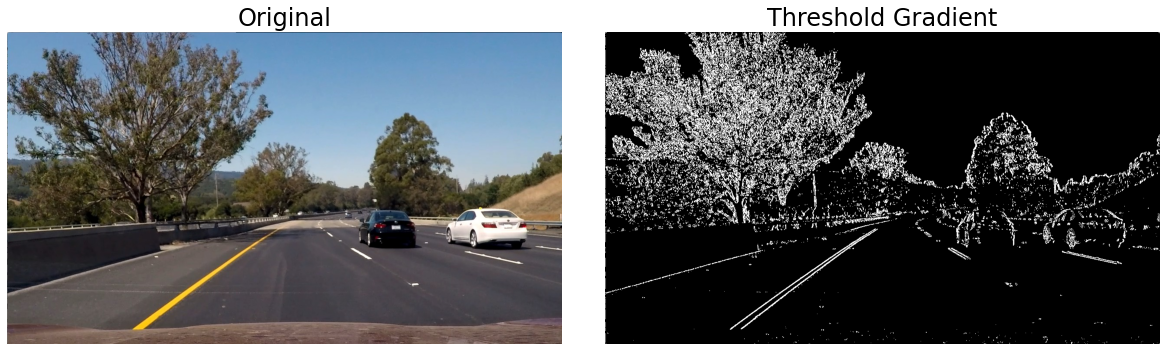

In [14]:
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

grad_binary = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100)

imgs = [image, grad_binary]
names = ['Original', 'Threshold Gradient']
plot_result(imgs, names, 1, 2)

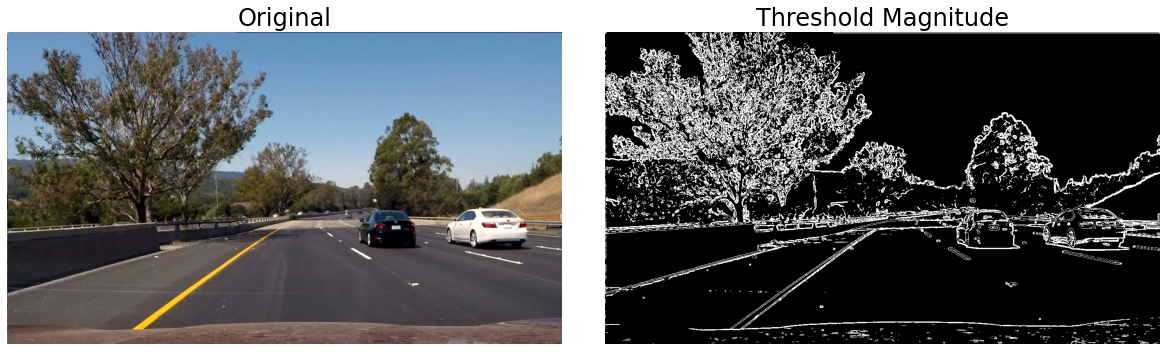

In [15]:
mag_binary = mag_thresh(gray, 5, (30, 100))

imgs = [image, mag_binary]
names = ['Original', 'Threshold Magnitude']
plot_result(imgs, names, 1, 2)

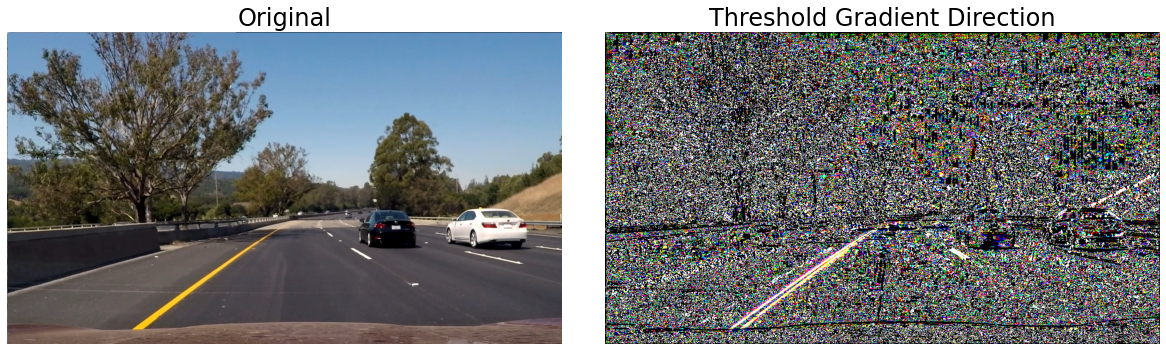

In [16]:
dir_binary = dir_threshold(image, 5, (0.7, 1.3))

imgs = [image, dir_binary]
names = ['Original', 'Threshold Gradient Direction']
plot_result(imgs, names, 1, 2)

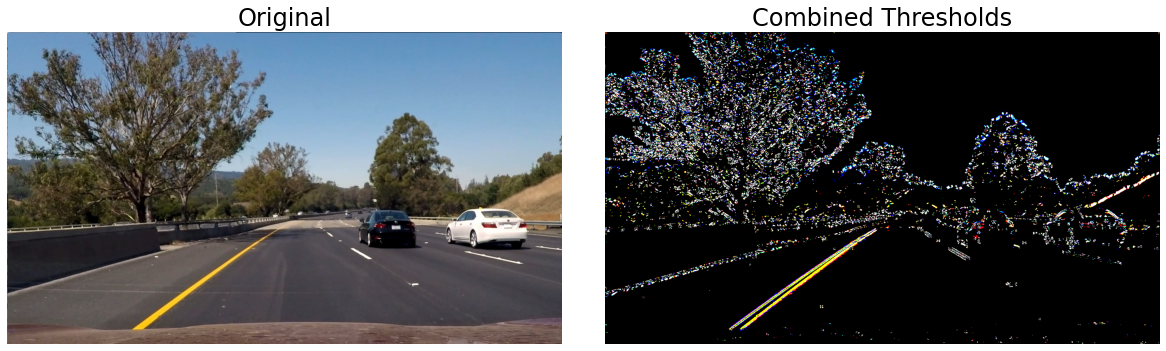

In [17]:
# Combined Gradient transform

# Sobel kernel size
ksize = 9

gradx = abs_sobel_thresh(image, 'x', thresh_min=30, thresh_max=100)
grady = abs_sobel_thresh(image, 'y', thresh_min=30, thresh_max=100)
mag_binary = mag_thresh(image, ksize, (30, 100))
dir_binary = dir_threshold(image, ksize, (0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

imgs = [image, combined]
names = ['Original', 'Combined Thresholds']
plot_result(imgs, names, 1, 2)

### Color Thresholds

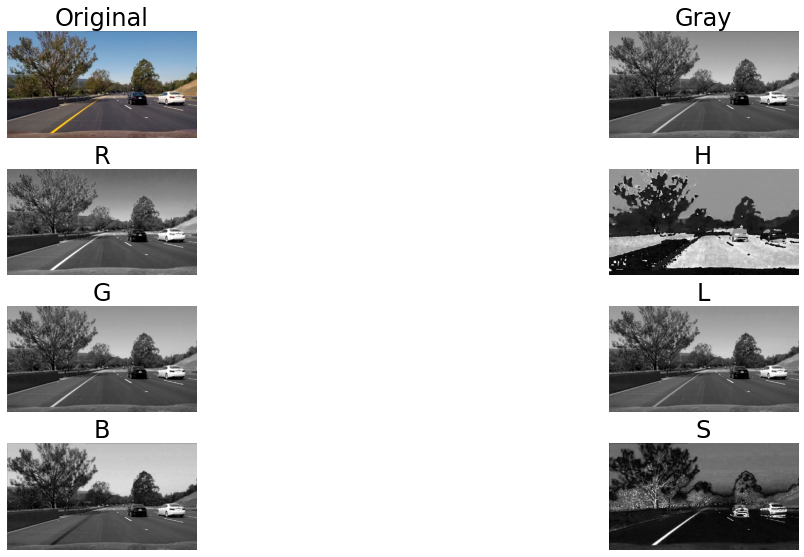

In [18]:
# RGB channels    
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]
    
# HLS channels    
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]
    
# Plot the result
imgs = [image, gray, r, h, g, l, b, s]
names = ['Original', 'Gray' ,'R', 'H', 'G', 'L', 'B', 'S']
plot_result(imgs, names, 4, 2)

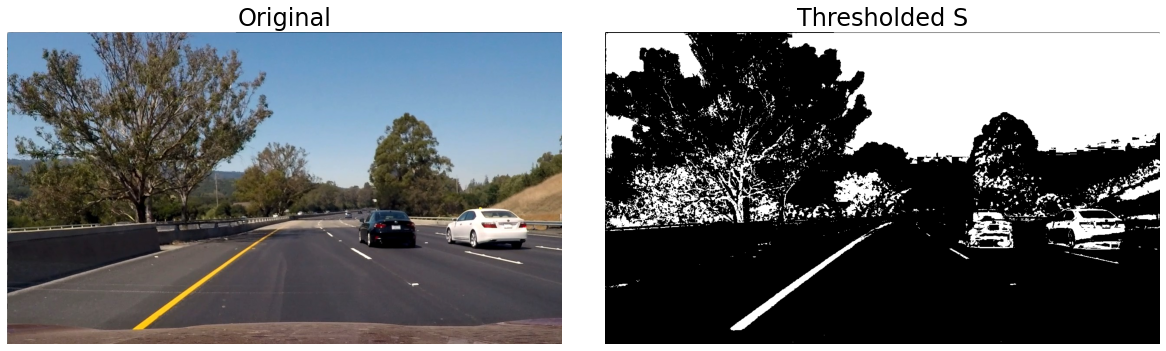

In [19]:
s_binary = s_thresh(image, thresh=(90, 255))

imgs = [image, s_binary]
names = ['Original', 'Thresholded S']
plot_result(imgs, names, 1, 2)

### Combined Thresholds

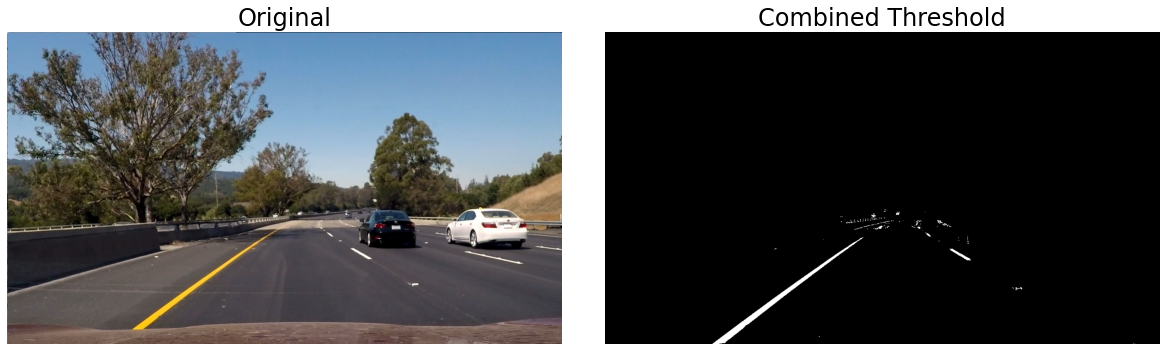

In [20]:
combined = thresholded(undistorted)
    
# Plot the result
imgs = [image, combined]
names = ['Original', 'Combined Threshold']
plot_result(imgs, names, 1, 2)

## Perspective Transform

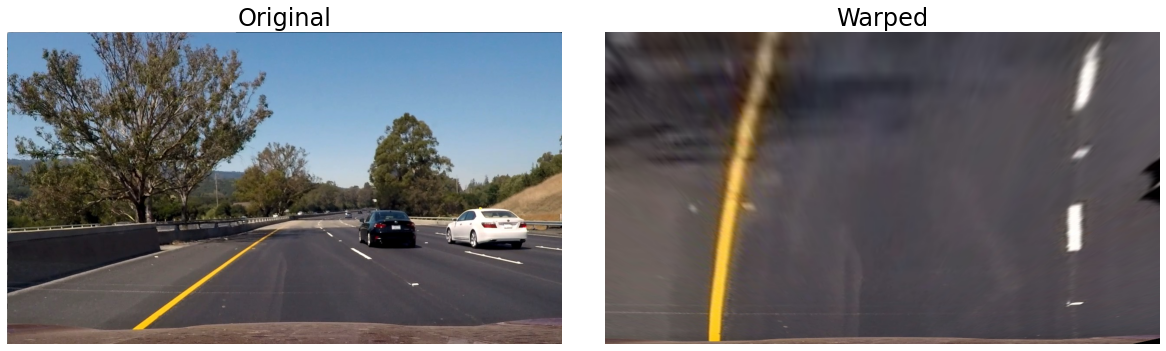

In [21]:
warped, M, Minv = warp(image)


imgs = [image, warped]
names = ['Original' ,'Warped']
plot_result(imgs, names, 1, 2)

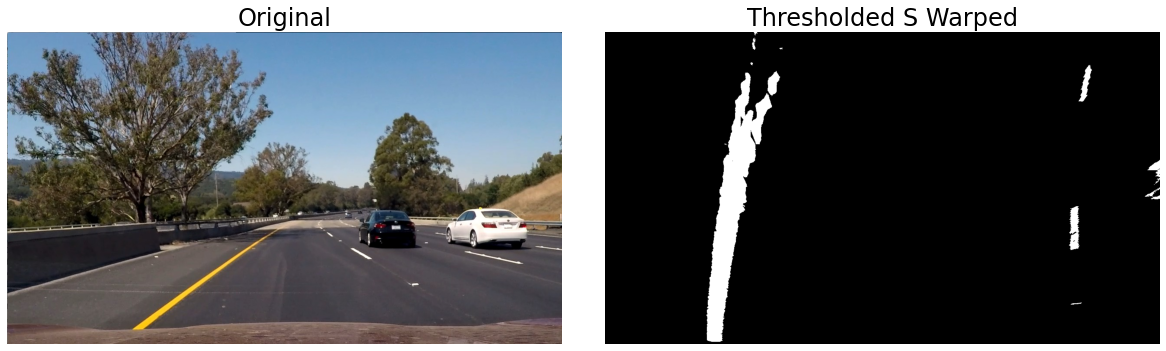

In [22]:
s_binary_warped = s_thresh(warped, thresh=(90, 255))

imgs = [image, s_binary_warped]
names = ['Original' ,'Thresholded S Warped']
plot_result(imgs, names, 1, 2)

## Detect lane pixels and fit to find the lane boundary

### Histogram Peaks

In [23]:
warped, M, Minv = warp(combined)

In [24]:
# Plot histogram for the lower half of the warped image
def hist(img):
    
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    
    half_width = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width
    
    return histogram, leftx_base, rightx_base

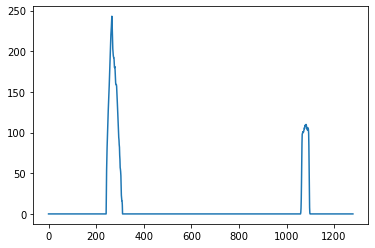

In [25]:
histogram, leftx_base, rightx_base = hist(warped)

plt.plot(histogram)

### Sliding Windows

In [26]:
def find_lane_pixels(img, return_img=False):
    
    # Take a histogram of the bottom half of the image
    histogram, leftx_base, rightx_base = hist(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # Wwidth of the windows +/- margin
    margin = 100
    # Minimum number of pixels found to recenter window
    minpix = 50        
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

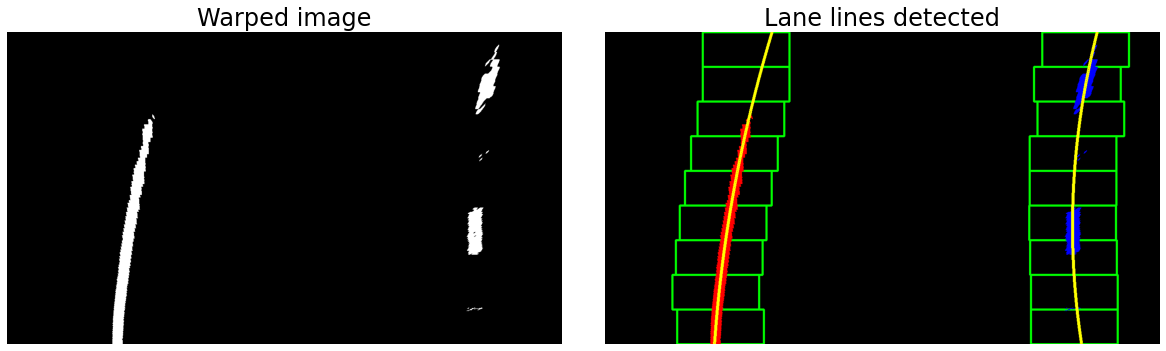

In [27]:
lines_fit, left_points, right_points, out_img = find_lane_pixels(warped, return_img=True)

imgs = [warped, out_img]
names = ['Warped image' ,'Lane lines detected']
plot_result(imgs, names, 1, 2)

### Search from Prior

In [28]:
def average_lines(previous_lines, new_line):

    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # We need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # Average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

In [29]:
def similar_lines(img, 
                  line_fits=None,
                  past_good_left_lines=[],
                  past_good_right_lines=[],
                  running_mean_difference_between_lines = 0,
                  return_img=False):
    if line_fits is None:
        return find_lane_pixels(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If no lines found, perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return find_lane_pixels(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # If no pixels were found return None
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Perform smoothing
    mean_difference = np.mean(right_fitx - left_fitx)
        
    if running_mean_difference_between_lines == 0:
        running_mean_difference_between_lines = mean_difference
        
    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return find_lane_pixels(img, return_img)
        else:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = average_lines(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = average_lines(past_good_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area 
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

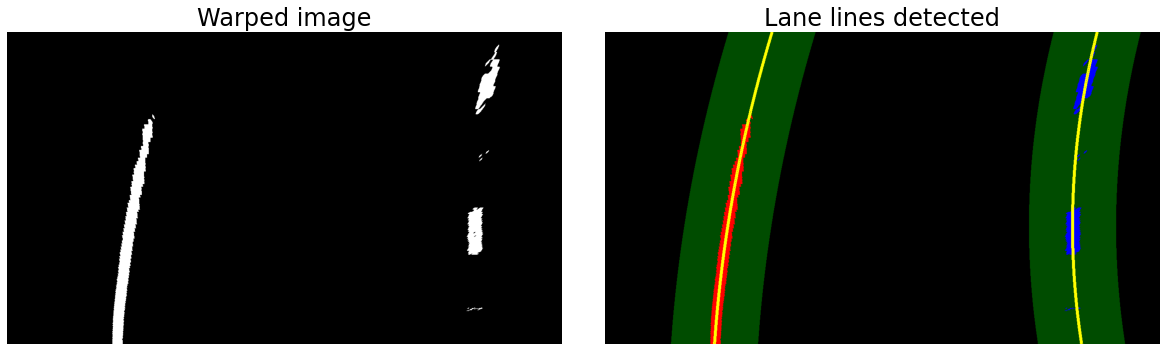

In [30]:
lines_fit, left_points, right_points, out_img = similar_lines(warped, lines_fit, return_img=True)

imgs = [warped, out_img]
names = ['Warped image' ,'Lane lines detected']
plot_result(imgs, names, 1, 2)

In [31]:
def curvature(leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  
    rightx = rightx[::-1]  
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 
    xm_per_pix = 3.7/800 
    
    # Fit new polynomials to x, y in real world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)

In [32]:
curvature_rad = curvature(leftx=left_points[0], rightx=right_points[0], img_shape = image.shape)

print('Left line curvature:', curvature_rad[0], 'm')
print('Right line curvature:', curvature_rad[1], 'm')

Left line curvature: 813.2706281443293 m
Right line curvature: 460.19658156292405 m


In [62]:
# Measure offset of the car from the center
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    
    # Horizontal mid point of the image
    img_midx = img_shape[1]//2
        
    # Position of the car w.r.t. the lane
    position = (leftx[-1] + rightx[-1])/2
    
    # Horizontal car offset
    offset = (img_midx - position) * xm_per_pix

    return offset

In [63]:
# Run the function
offset = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=image.shape)

print ('Car offset from center:', offset, 'm.')

Car offset from center: -0.16614187225568597 m.


## Warp the detected lane boundaries onto the original image

In [70]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using Minv
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

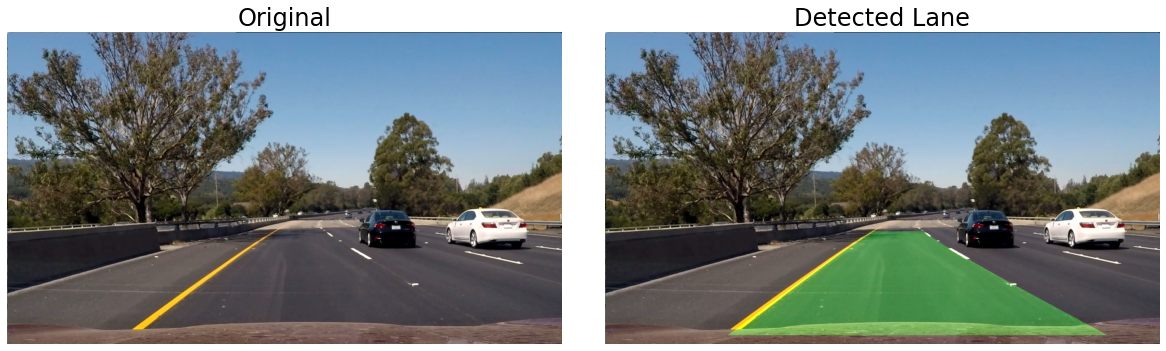

In [72]:
lane = draw_lane(image, warped, left_points, right_points, Minv)

imgs = [image, lane]
names = ['Original' ,'Detected Lane']
plot_result(imgs, names, 1, 2)

## Output visual display of the lane boundaries with curvature and offset

In [73]:
def display_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    
    # Calculate curvature
    curvature_rad = curvature(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate offset
    offset = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rad[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rad[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offset), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

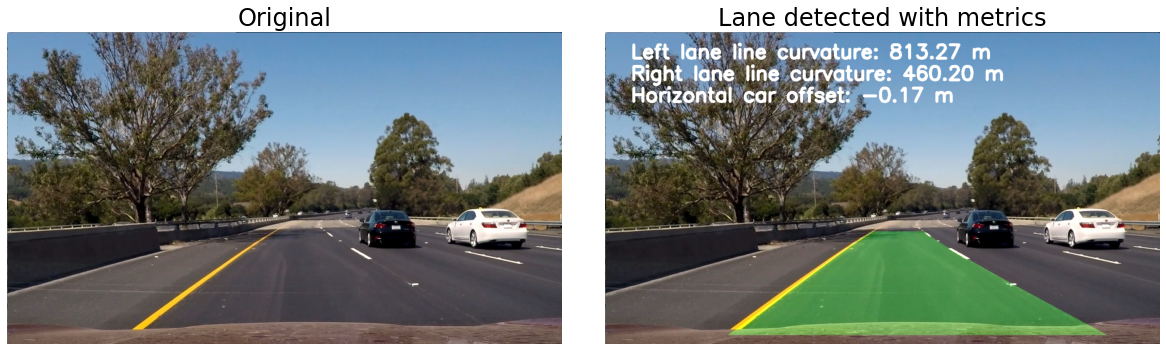

In [74]:
out_img = display_metrics(lane, leftx=left_points[0], rightx=right_points[0])

# Plot the result
imgs = [image, out_img]
names = ['Original' ,'Lane detected with metrics']
plot_result(imgs, names, 1, 2)

## Complete Pipeline

In [37]:
class Pipeline:
    def __init__(self, cal_path):
        # Make a list of calibration images

        # Calibrate camera
        self.mtx, self.dist = camera_calibration(cal_path)
        
        # Reinitialize 
        self.lines_fit = None
        self.past_good_left_lines = []
        self.past_good_right_lines = []
        self.running_mean_difference_between_lines = 0

    def __call__(self, img):
        
        # STEP 1: UNDISTORT (using camera calibration step matrix and dist)
        undistorted = undistort_image(img, self.mtx, self.dist)
        
        # STEP 2: GAUSSIAN BLUR
        blurred = gaussian_blur(undistorted, kernel=3)

        # STEP 3: APPLY COLOR SPACE TRANSFORM AND SOBEL THRESHOLDING
        combined = get_thresholded_image(blurred)
        
        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        # STEP 4: WARP BINARY IMAGE INTO TOP-DOWN VIEW
        warped, M, Minv = warp(combined, src_coordinates, dst_coordinates)
        
        
        # STEP 5: Detect lane pixels and fit to find the lane boundary
        self.lines_fit, left_points, right_points, out_img = detect_similar_lines(warped, 
                                                                                  self.lines_fit, 
                                                                                  self.past_good_left_lines,
                                                                                  self.past_good_right_lines,
                                                                                  self.running_mean_difference_between_lines,
                                                                                  return_img=True,)

        # STEP 6: Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(img, warped, left_points, right_points, Minv)
            
        # STEP 7: Add metrics to the output img
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

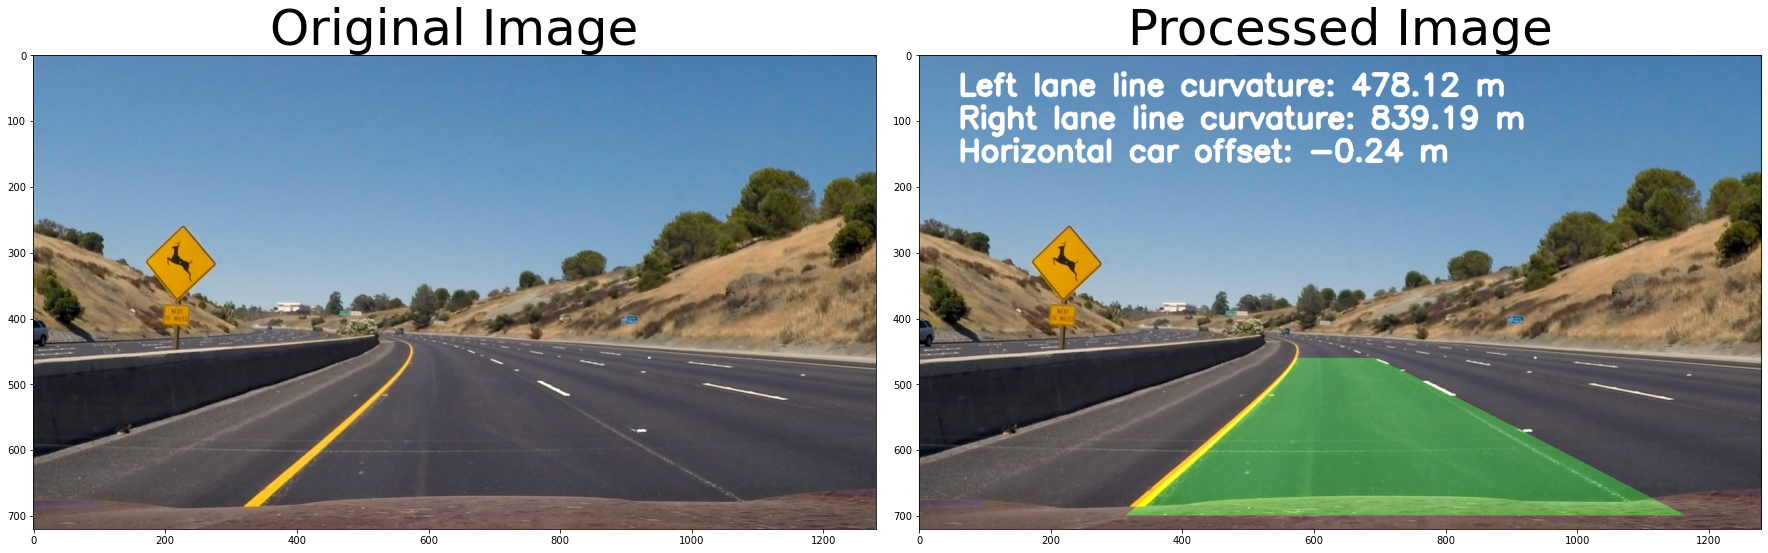

In [38]:
img = mpimg.imread('test_images/test2.jpg')

# Process video frames with our 'process_image' function
process_image = Pipeline('./camera_cal/calibration*.jpg')

# Apply pipeline
processed = process_image(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [39]:
def apply_video(input_video, output_video):

    # Process video frames with our 'process_image' function
    process_image = Pipeline('./camera_cal/calibration*.jpg')
    
    ## You may uncomment the following line for a subclip of the first 5 seconds
    #clip1 = VideoFileClip(input_video).subclip(0,5)
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_video, audio=False)
    
    print("Apply video pipeline: SUCCESS!")

In [40]:
input_video = './project_video.mp4'
output_video = './project_video_output.mp4'

apply_video(input_video, output_video)

t:   0%|                                                                                                        | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
Wall time: 2min 25s
Apply video pipeline: SUCCESS!


In [41]:
input_video = './challenge_video.mp4'
output_video = './challenge_video_output.mp4'
apply_video(input_video, output_video)

t:   0%|                                                                                                         | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./challenge_video_output.mp4.
Moviepy - Writing video ./challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./challenge_video_output.mp4
Wall time: 56.1 s
Apply video pipeline: SUCCESS!


In [43]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))